# Recap

- We tested the single agent setting for a different task.
- The landmarks were always fixed at time of the environment initialization.
- It was shown that the agent learned to navigate to any part of the map.
- Particularly, when the agent's starting coordinate was kept fixed and overflow would happen. Random restart is an essencial part of exploration.
- The optimal policies are not deterministic -- the temperature parameter $\tau$ that regulates the entropy was tested for **1**, **2**, **3**, **5** and **10**.

## Findings

1. The most useful task is to randomly restart the landmarks.
2. Regularization, via parameter clipping, improved learning.
3. The optimal value for $\tau = 5.0$.


# Duo Task

## Goal:

### Agents must learn how to navigate to a target landmark, while avoiding other agents.

- Both agents and landmarks are restarted at the begining of each episode. And agents are assigned a landmark they must navigate to, they must through trial and error be find which landmark they were assigned to.
- States are the coordinates to the other agent and to both landmarks.
- Reward is defined by the distance from an agent to its assigned landmark. If they collide both receive an extra reward=-1.



The objective of this notebook is to compare three learning settings.

1. Centralized Actor Critic

    - Single agent.
    - Fully observable setting.
    - Learnings using the average reward from both players.
2. Cooperative Actor Critic

    - Independent agents.
    - Fully observable setting.
    - Learnings using the average reward from both players.

3. Independent Learners Actor Critic

    - Independent agents.
    - Fully observable setting.
    - Individual rewards.

## Section A: First attempt.


## Settings


1. We compare the three models above. 
2. Initially, $\tau = 100$ and it falls linearly with the number of episodes (`explore_episodes=3000`). 
3. Each test dataframe consists of the DataFrame.describe() statistics from **N** = 30 independent random trials, each of which consisting of rollouts of `M=100`, with $\tau$ set to a predetermined value.

Parameters:
```
"""Configuration"""
# The hyperparameter for the environment: Number of agents.
N_AGENTS = 2
# The pipeline agent
AGENT_TYPE = 'ActorCriticCentral'
# Alpha learning rate for the critic
ALPHA = 0.5
# Learning rate for the actor
BETA = 0.3
# Final temperature parameter
TAU = 5.0
# The weighting for the moving average
ZETA = 0.01
# The episodes with temperature greater than TAU
EXPLORE_EPISODES = 3000
# The total number of training episodes.
EPISODES = 7500
# Applies temperature parameter from 100-TAU
EXPLORE = True  # WHETER OR NOT WE USE EXPLORATION
CONSENSUS_MATRIX_TYPE = 'metropolis'
# Maximum number of edges.
CONSENSUS_MAX_EDGES = 0
# Stop training at every checkpoint_interval
CHECKPOINT_INTERVAL = 500
# Evaluate checkpoint for checkpoint evaluations
CHECKPOINT_EVALUATIONS = 32
# Training_cycle = train for checkpoint interval + checkpoint_evaluation
TRAINING_CYCLES = EPISODES // CHECKPOINT_INTERVAL
# Seed for individual runs, e.g, `python central.py`
SEED = 1
# The path that the experiments will be saved at.
BASE_PATH = 'data/00_duo_w08'
# The number of pipeline workers
N_WORKERS = 15
# Those are the training random seeds, i.e., `.\pipeline`
PIPELINE_SEEDS = [
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76
]

```

## 1) Central Agent

In [1]:
import pandas as pd
BASE_PATH = '08_duo_torch/'

central_df = pd.read_csv(BASE_PATH + '01_central_torch/02/pipeline-rollouts-summary.csv', sep=',', index_col=0)
indep_df = pd.read_csv(BASE_PATH + '03_independent_learners/02/pipeline-rollouts-summary.csv', sep=',', index_col=0)

def describe(dataframe: pd.DataFrame, label: str) -> pd.DataFrame:
    """Describes the dataframe
    
    Parameters
    ----------
    dataframe: pd.DataFrame
        A dataframe with description N independent rollouts.
        Each consisting of M timesteps.
        Trials are in the columns and rows are statistics.
        The result of df.describe()
   
    Returns
    -------
    dataframe: pd.DataFrame
        A description of the average return.
    
    """
    df = dataframe.drop(['std', 'count', '25%', '50%', '75%'], axis=0)
    ts = df.T.describe()['mean']
    ts.name = label
    return ts.to_frame()

In [2]:
dataframes = []
dataframes.append(describe(central_df, label='central'))
dataframes.append(describe(indep_df, label='independent'))
noregdf = pd.concat(dataframes, axis=1)
noregdf

,central,independent
count,30.000000,30.000000
mean,-1.441451,-1.436881
std,0.621149,0.755187
min,-2.676111,-3.139894
25%,-1.863735,-1.909306
50%,-1.315542,-1.200203
75%,-0.971401,-0.951459
max,-0.292699,-0.312311


BASE_PATH = '08_duo_torch/00_central/02'

### 1.1 Rollout Simulation

GIF from the best performing training.

![pipeline-central-simulation](08_duo_torch/01_central_torch/02/simulation-pipeline-best.gif)

### 1.2 Rollout Graph

```
max_average_reward:-0.2927      simulation_reward:-0.8105
```
![pipeline-central-simulation](08_duo_torch/01_central_torch/02/evaluation_rollout_n2_num04.png)

In [4]:
df = pd.read_csv('08_duo_torch/01_central_torch/02/evaluation_rollout-num04.csv', sep=',')
df.sum()

Unnamed: 0    4950.000000
1              -59.192096
dtype: float64

### 1.3 Train<a name="A-1.3"></a> 



![pipeline-central-train-30](08_duo_torch/01_central_torch/02/train_pipeline_m30.png)
![rollout-central-train-30](08_duo_torch/01_central_torch/02/train_rollout_m30.png)

### A.1.4 Collision 

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

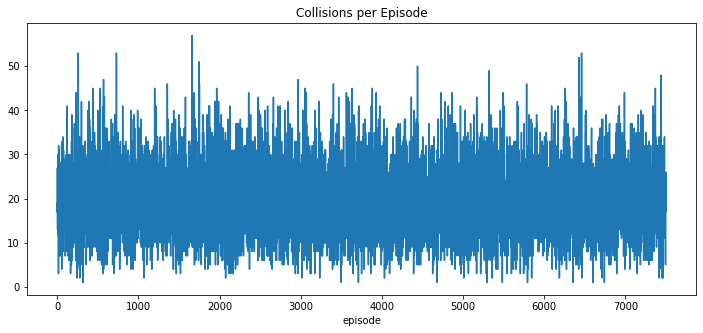

In [5]:
FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)
import pandas as pd
BASE_PATH = '08_duo_torch/01_central_torch/02'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

### A.1.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

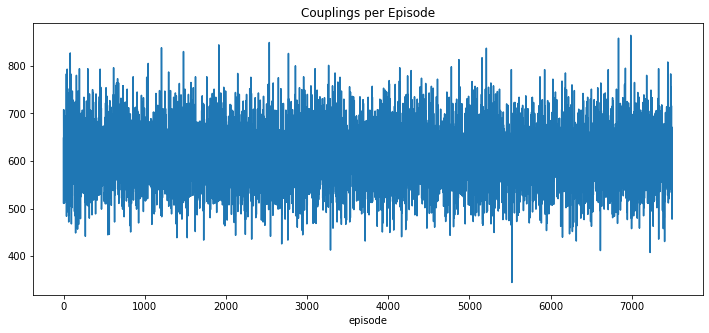

In [6]:
BASE_PATH = '08_duo_torch/01_central_torch/02'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)

## 2) Independent Learners Actor Critic

GIF from the best performing training.

BASE_PATH = '08_duo_torch/03_independent_learners/02'

![pipeline-independent-simulation](08_duo_torch/03_independent_learners/02/simulation-pipeline-best.gif)

### 2.2 Rollout Graph

```
max_average_reward:-0.3123      simulation_reward:-0.4147
```

![pipeline-distributed-rollout](08_duo_torch/03_independent_learners/02/evaluation_rollout_n2_num11.png)

In [14]:
df = pd.read_csv('08_duo_torch/03_independent_learners/02/evaluation_rollout-num09.csv', sep=',')
df.sum()

Unnamed: 0    4950.00000
1              -75.30002
dtype: float64

### 2.3 Train<a name="A-2.3"></a> 



![pipeline-distributed-train-30](08_duo_torch/03_independent_learners/02/train_pipeline_m30.png)
![rollout-distributed-train-30](08_duo_torch/03_independent_learners/02/train_rollout_m30.png)

### A.2.4 Collision 

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

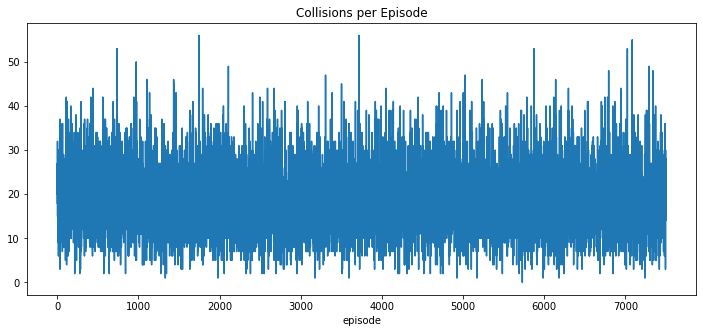

In [12]:
FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)
import pandas as pd
BASE_PATH = '08_duo_torch/03_independent_learners/02'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

### A.2.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

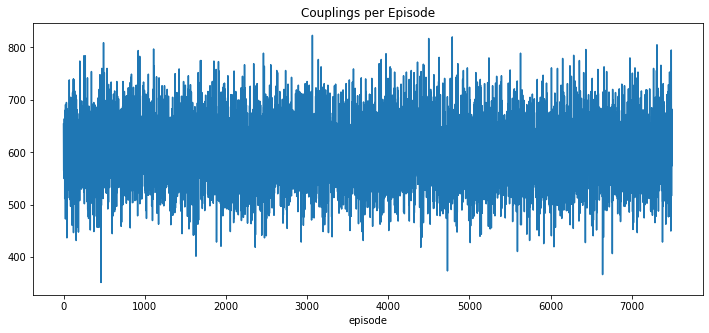

In [13]:
BASE_PATH = '08_duo_torch/03_independent_learners/02'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)

## 3) Independent Learners Actor Critic

GIF from the best performing training.


![pipeline-independent-simulation](00_duo_w08v2/02_independent_learners/02/simulation-pipeline-best.gif)

### A.3.2 Rollout Graph


![pipeline-independent-rollout](00_duo_w08v2/02_independent_learners/02/evaluation_rollout_n2_num18.png)

In [47]:
df = pd.read_csv('00_duo_w08v2/02_independent_learners/02/evaluation_rollout-num04.csv', sep=',')
df.sum()

Unnamed: 0    4950.000000
1              -44.671239
dtype: float64

### 3.3 Train <a name="A-3.3"></a> 



![pipeline-independent-train-30](00_duo_w08/02_independent_learners/02/train_pipeline_m30.png)
![rollout-independent-train-30](00_duo_w08/02_independent_learners/02/train_rollout_m30.png)

### A.3.3 Collision 

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

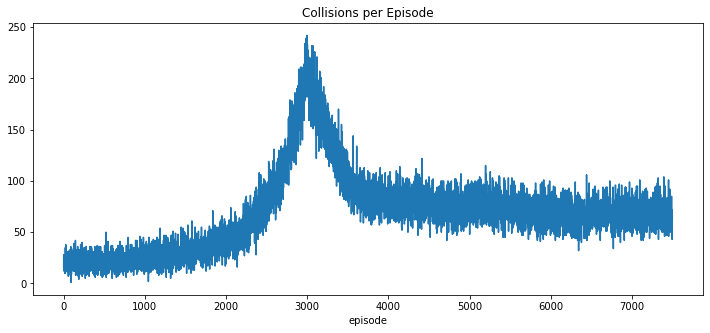

In [49]:
FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)
import pandas as pd
BASE_PATH = '00_duo_w08v2/02_independent_learners/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

### A.2.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

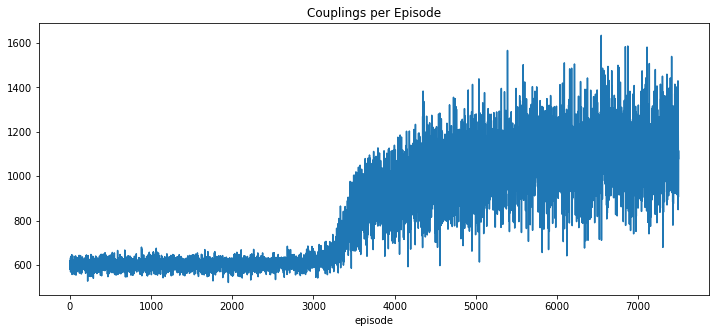

In [48]:
BASE_PATH = '00_duo_w08v2/02_independent_learners/02'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)

## 4) Leaderboard <a name="A-leaderboard"></a> 

In [26]:
joint_df = pd.read_csv(BASE_PATH + '01_distributed_learners/02/pipeline-rollouts.csv', sep=',', index_col=0)
joint_df.mean(axis=0)

47   -1.747653
48   -0.865905
49   -0.872531
50   -1.383480
51   -1.381466
52   -0.886356
53   -1.225550
54   -1.075245
55   -1.335412
56   -0.763532
57   -1.352567
58   -0.674196
59   -0.906326
60   -1.213349
61   -0.884846
62   -0.674232
63   -1.058279
64   -0.579872
65   -0.938370
66   -0.778399
67   -0.681507
68   -1.089986
69   -0.852335
70   -1.065872
71   -0.750138
72   -0.921136
73   -1.414591
74   -0.921678
75   -1.339798
76   -0.494297
dtype: float64

In [28]:
independent_df = pd.read_csv(BASE_PATH + '02_independent_learners/02/pipeline-rollouts-top03.csv', sep=',', index_col=0)
independent_df.mean(axis=0)

51   -0.446712
66   -0.507351
63   -0.529060
dtype: float64

In [33]:
independent_df.mean(axis=0).min().index

AttributeError: 'numpy.float64' object has no attribute 'index'

In [38]:
joint_df = pd.read_csv(BASE_PATH + '01_distributed_learners/02/pipeline-rollouts-top03.csv', sep=',', index_col=0)
joint_df.mean(axis=0).idxmax()

'76'

1. The first thing to note is that the Evaluation Rollouts show that the central agent presents one colliison, while the joint action learner presents two collisions and the independent learner presents three collisions. Indicating that **cooperation** is a helpful means to avoid collisions and that **coordination** is an effective way to achieve that.
2. However, we see from table [Leaderboard 1000](#leaderboard-1000) that the central agent underperforms. A hint of the reason is given by the training plots [Plot 1.3 Central Training](#A-1.3) [Plot 2.3 Joint Training](#A-2.3), [Plot 3.3 Independent Training](#A-3.3). It seems that the central agent hasn't had change to learn -- It must learn 125 actions while each other agent has to learn from 5 actions.


# Section B: Successful Attempt<a name="B-section"></a> 

We set `episodes=5000` and `explore_episodes=4975`.

## 1) Central Agent

BASE_PATH = 'data/16_duo/03_tau05/5000/00_central/02'

### 1.1 Rollout Simulation

GIF from the best performing training.

![pipeline-central-simulation](16_duo/03_tau05/5000/00_central/02/simulation-pipeline-best.gif)

### 1.2 Rollout Graph


![pipeline-central-simulation](16_duo/03_tau05/5000/00_central/02/evaluation_rollout_num06.png)

### 1.3 Train<a name="A-1.3"></a> 



![pipeline-central-train-30](16_duo/03_tau05/5000/00_central/02/train_pipeline_m30.png)
![rollout-central-train-30](16_duo/03_tau05/5000/00_central/02/train_rollout_m30.png)

## 2) Cooperative Actor Critic

GIF from the best performing training.


![pipeline-joint-simulation](16_duo/03_tau05/5000/01_joint_learners/02/simulation-pipeline-best.gif)

### 2.2 Rollout Graph


![pipeline-joint-rollout](16_duo/03_tau05/5000/01_joint_learners/02/evaluation_rollout_num01.png)

### 2.3 Train<a name="B-2.3"></a> 



![pipeline-joint-train-30](16_duo/03_tau05/5000/01_joint_learners/02/train_pipeline_m30.png)
![rollout-joint-train-30](16_duo/03_tau05/5000/01_joint_learners/02/train_rollout_m30.png)

## 3) Independent Learners Actor Critic

GIF from the best performing training.


![pipeline-independent-simulation](16_duo/03_tau05/5000/02_independent_learners/02/simulation-pipeline-best.gif)

### 3.2 Rollout Graph


![pipeline-independent-rollout](16_duo/03_tau05/5000/02_independent_learners/02/evaluation_rollout_num01.png)

### 3.3 Train <a name="B-3.3"></a> 



![pipeline-independent-train-30](16_duo/03_tau05/5000/02_independent_learners/02/train_pipeline_m30.png)
![rollout-independent-train-30](16_duo/03_tau05/5000/02_independent_learners/02/train_rollout_m30.png)

## 4) Leaderboard 5000<a name="B-leaderboard"></a> 

In [34]:
import pandas as pd
BASE_PATH = '16_duo/03_tau05/5000/'

central_df = pd.read_csv(BASE_PATH + '00_central/02/pipeline.csv', sep=',', index_col=0)
joint_df = pd.read_csv(BASE_PATH + '01_joint_learners/02/pipeline.csv', sep=',', index_col=0)
indep_df = pd.read_csv(BASE_PATH + '02_independent_learners/02/pipeline.csv', sep=',', index_col=0)

In [35]:
dataframes = []
dataframes.append(describe(central_df, label='central'))
dataframes.append(describe(joint_df, label='joint'))
dataframes.append(describe(indep_df, label='indepent'))
noregdf = pd.concat(dataframes, axis=1)
noregdf

,central,joint,indepent
count,30.000000,30.000000,30.000000
mean,-0.707014,-0.936407,-0.884910
std,0.174991,0.160264,0.137636
min,-1.119460,-1.240960,-1.264698
25%,-0.870943,-1.041689,-0.953044
50%,-0.645521,-0.929262,-0.854733
75%,-0.591891,-0.831467,-0.782187
max,-0.475165,-0.637744,-0.684747


In [37]:
BASE_PATH = '16_duo/01_tau02/5000/'

central_df = pd.read_csv(BASE_PATH + '00_central/02/pipeline.csv', sep=',', index_col=0)
central_df.T.describe()

,count,mean,std,min,25%,50%,75%,max
count,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,100.0,-0.789356,0.262101,-1.614022,-0.910463,-0.745515,-0.628947,-0.363709
std,0.0,0.191350,0.084206,0.250240,0.245691,0.216647,0.205738,0.185291
min,100.0,-1.176989,0.103623,-2.108609,-1.345804,-1.216842,-1.130174,-0.761060
25%,100.0,-0.920646,0.213262,-1.781672,-1.037202,-0.884421,-0.740292,-0.514763
50%,100.0,-0.775608,0.246014,-1.672889,-0.890028,-0.740801,-0.600437,-0.333291
75%,100.0,-0.674831,0.317402,-1.450856,-0.757286,-0.600869,-0.510171,-0.198981
max,100.0,-0.390616,0.436406,-0.989545,-0.443964,-0.335705,-0.284563,-0.060358
